In [ ]:
%%capture
# !pip install opendatasets
# import opendatasets as od
# od.download("https://www.kaggle.com/datasets/mahmoudima/mma-facial-expression","/data")

In [ ]:
# !pip install opencv-python
# !pip install imgaug
# !pip install scikit-learn
# !pip install mtcnn

In [ ]:
%store

In [ ]:
#make a function that calculates the files in a directory and subdirectories
import os
def count_files(path):
    count = 0
    for root, dirs, files in os.walk(path):
        count += len(files)
    return count

In [ ]:
print(count_files("data/test"), count_files("data/train"), count_files("data/valid"))

In [ ]:
def load_dataset(folder_path):
    images = []
    labels = []
    emotions = []
    
    for emotion in os.listdir(folder_path):
        emotion_folder = os.path.join(folder_path, emotion)
        if os.path.isdir(emotion_folder):
            emotions.append(emotion)  # Store the emotion in the order encountered
            for image_file in os.listdir(emotion_folder):
                image_path = os.path.join(emotion_folder, image_file)
                image = cv2.imread(image_path)
                if image is not None:
                    images.append(image)
                    labels.append(emotion)
    
    return images, labels, emotions

In [ ]:
import os
import cv2

# Example usage:
train_folder = "data/train"
validation_folder = "data/valid"
test_folder = "data/test"

train_images, train_labels, train_emotions = load_dataset(train_folder)
%store train_images
%store train_labels
%store train_emotions

In [ ]:
validation_images, validation_labels, validation_emotions = load_dataset(validation_folder)
%store validation_images
%store validation_labels
%store validation_emotions

In [ ]:
test_images, test_labels, test_emotions = load_dataset(test_folder)
%store test_images
%store test_labels         #save for later
%store test_emotions

In [ ]:
print("Train emotions order:", train_emotions)
print("Validation emotions order:", validation_emotions)
print("Test emotions order:", test_emotions)

In [ ]:
len(train_images), len(validation_images), len(test_images)

In [ ]:
%store -r

In [ ]:
import imgaug.augmenters as iaa

def augment_dataset(images, labels):
    augmented_images = []
    augmented_labels = []

    seq = iaa.Sequential([
        iaa.Fliplr(0.5),  # flip horizontally with a 50% chance
        iaa.Affine(rotate=(-10, 10)),  # rotate images by -10 to 10 degrees
        iaa.GaussianBlur(sigma=(0, 1.0)),  # apply Gaussian blur with sigma between 0 and 1.0
        iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255)),  # add Gaussian noise
        iaa.Resize({"height": 64, "width": 64})  # resize images to 64x64 pixels
    ], random_order=True)

    for image, label in zip(images, labels):
        augmented_images.extend(seq(images=[image] * 3))  # Augment each image 3 times for increased diversity
        augmented_labels.extend([label] * 3)

    return augmented_images, augmented_labels

# Example usage:
augmented_train_images, augmented_train_labels = augment_dataset(train_images, train_labels)
augmented_test_images, augmented_test_labels = augment_dataset(test_images, test_labels)
augmented_validation_images, augmented_validation_labels = augment_dataset(validation_images, validation_labels)    

In [ ]:
# %store augmented_train_images
# %store augmented_train_labels
# %store augmented_test_images
# %store augmented_test_labels
# %store augmented_validation_images
# %store augmented_validation_labels

In [ ]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

def preprocess_images(images):
    preprocessed_images = []
    for image in images:
        # Convert image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Resize image to a consistent size (e.g., 64x64)
        resized = cv2.resize(gray, (64, 64))
        # Normalize pixel values to [0, 1]
        normalized = resized / 255.0
        preprocessed_images.append(normalized)
    
    return np.array(preprocessed_images)

# Preprocess augmented training images
preprocessed_train_images = preprocess_images(augmented_train_images)
# Preprocess validation and testing images
preprocessed_validation_images = preprocess_images(augmented_validation_images)
#preprocessed_test_images = preprocess_images(augmented_test_images)


# Split augmented training data into training and validation sets
"""from sklearn.model_selection import train_test_split
preprocessed_train_images = train_images
preprocessed_validation_images = validation_images
preprocessed_test_images = test_images
augmented_train_labels = train_labels"""


preprocessed_train_images, preprocessed_validation_images, train_labels, validation_labels = train_test_split(
    preprocessed_train_images, augmented_train_labels, test_size=0.4, random_state=42
)

In [ ]:
augmented_test_images.clear(), augmented_test_labels.clear(), augmented_train_images.clear(), augmented_train_labels.clear(), augmented_validation_images.clear(), augmented_validation_labels.clear()

In [ ]:
#%store preprocessed_train_images            #save for later
#%store preprocessed_validation_images       #save for later

import pickle

# Save variables
data = {
    'preprocessed_train_images': preprocessed_train_images,
    'preprocessed_validation_images': preprocessed_validation_images,
    'train_labels': train_labels,
    'validation_labels': validation_labels,
    # Add more variables as needed
}

with open('variables.pkl', 'wb') as file:
    pickle.dump(data, file)

In [ ]:
# Load variables
import pickle

with open('variables.pkl', 'rb') as file:
    data = pickle.load(file)

preprocessed_train_images = data['preprocessed_train_images']
preprocessed_validation_images = data['preprocessed_validation_images']
train_labels = data['train_labels']
validation_labels = data['validation_labels']

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Training

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Define the CNN model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Reshape preprocessed images for CNN input
train_images_reshaped = np.expand_dims(preprocessed_train_images, axis=-1)
validation_images_reshaped = np.expand_dims(preprocessed_validation_images, axis=-1)

# Verify the shape and data type
print(train_images_reshaped.shape)  # Check the shape
print(train_images_reshaped.dtype)  # Check the data type

# Confirm the number of channels
# If images are RGB, adjust the input shape accordingly

# Define a mapping of emotions to numerical labels
emotion_mapping = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'neutral': 4,
    'sad': 5,
    'surprise': 6
}

# Convert emotion labels to numerical labels
train_labels_encoded = np.array([emotion_mapping[label] for label in train_labels])
validation_labels_encoded = np.array([emotion_mapping[label] for label in validation_labels])

# Set the batch size
batch_size = 2

# Train the model with batch processing and keep track of metrics

with tf.device('/gpu:0'):
    history = model.fit(train_images_reshaped, train_labels_encoded, batch_size=batch_size, epochs=20, validation_data=(validation_images_reshaped, validation_labels_encoded))

# Plot the accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Other Approaches

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Define the base CNN model for transfer learning
base_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax')
])

# Load the pre-trained weights (e.g., trained on a larger dataset)
base_model.load_weights('emotion_detection_model.h5')

# Create a new model by adding a few additional layers on top of the base model
model = models.Sequential([
    base_model,
    layers.Dense(64, activation='relu'),
    layers.Dense(7, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Reshape preprocessed images for CNN input
train_images_reshaped = np.expand_dims(preprocessed_train_images, axis=-1)
validation_images_reshaped = np.expand_dims(preprocessed_validation_images, axis=-1)

# Convert emotion labels to numerical labels
emotion_mapping = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'neutral': 4,
    'sad': 5,
    'surprise': 6
}

train_labels_encoded = np.array([emotion_mapping[label] for label in train_labels])
validation_labels_encoded = np.array([emotion_mapping[label] for label in validation_labels])

# Set the batch size
batch_size = 64

# Train the model on a subset of data (e.g., first 1000 samples)
model.fit(train_images_reshaped[:1000], train_labels_encoded[:1000], batch_size=batch_size, epochs=10)

# Train the model on additional data (e.g., next 1000 samples)
model.fit(train_images_reshaped[1000:2000], train_labels_encoded[1000:2000], epochs=1000)

# Evaluate the model on the validation data
model.evaluate(validation_images_reshaped, validation_labels_encoded)


In [ ]:
# Save the trained model
model.save('emotion_detection_model_v2.h5')

<h4>To perform test on a single image</h4>

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import numpy as np

# Load the saved model
model = load_model('emotion_detection_model.h5')

# Load and preprocess the new image
image = cv2.imread('fear.jpg', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (64, 64))
image = image.astype('float32') / 255.0
image = np.expand_dims(image, axis=0)
image = np.expand_dims(image, axis=-1)

#show image
plt.imshow(image[0,:,:,0], cmap='gray')
plt.show()

# Make predictions
predictions = model.predict(image)
predicted_class = np.argmax(predictions[0])

# Print the predicted class and probability distribution
# angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'
emotion_mapping = {
    0: 'angry',
    1: 'disgust',
     2: 'fear',
     3: 'happy',
     4: 'neutral',
     5: 'sad',
     6: 'surprise'
}

predicted_emotion = emotion_mapping[predicted_class]
print('Predicted Emotion:', predicted_emotion)
print('Probability Distribution:', predictions[0])


<h4>To perform test on multiple images stored in a folder </h4>

1/1 [==============================] - 5s 5s/step


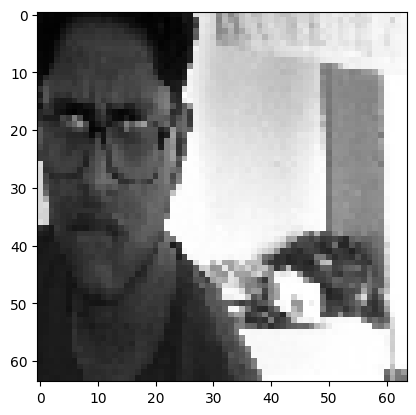

File: testAngry.jpg
Predicted Emotion: happy
Probability Distribution: [3.2747815e-11 7.5917409e-28 2.5853411e-05 9.9992979e-01 4.3549586e-05
 8.4533849e-07 5.8613955e-14]
------------------------
1/1 [==============================] - 0s 39ms/step


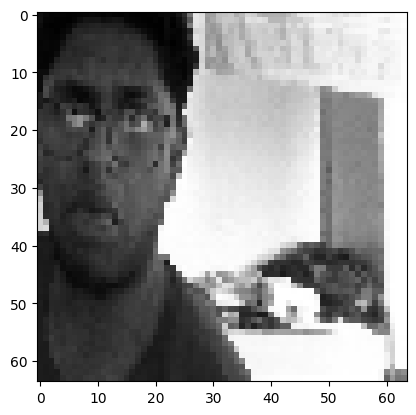

File: testDisgust.jpg
Predicted Emotion: happy
Probability Distribution: [3.6216490e-09 1.8237550e-25 7.1179535e-04 9.9903929e-01 2.3817534e-04
 1.0771260e-05 1.0959710e-11]
------------------------
1/1 [==============================] - 0s 40ms/step


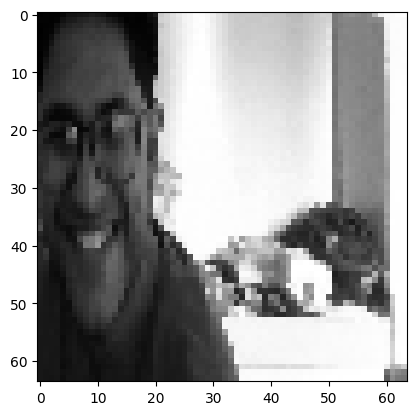

File: testHappy.jpg
Predicted Emotion: surprise
Probability Distribution: [1.7477076e-03 3.2750241e-17 2.1747189e-02 1.7169334e-08 3.3521279e-09
 3.6552871e-07 9.7650468e-01]
------------------------
1/1 [==============================] - 0s 41ms/step


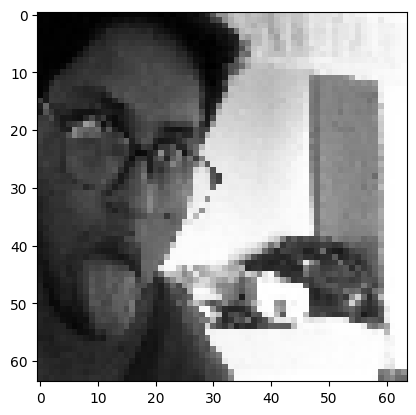

File: testNeutrak.jpg
Predicted Emotion: happy
Probability Distribution: [8.5321064e-12 2.0176236e-28 9.2018963e-06 9.9996161e-01 2.8816610e-05
 4.2348825e-07 1.2257122e-14]
------------------------
1/1 [==============================] - 0s 40ms/step


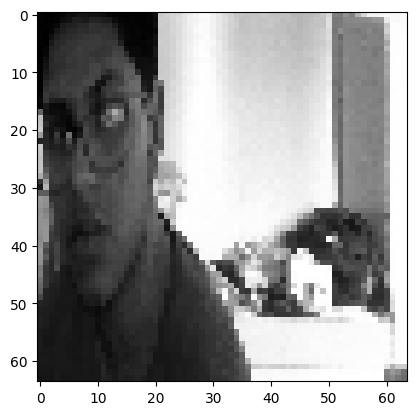

File: testNeutral.jpg
Predicted Emotion: angry
Probability Distribution: [9.9993062e-01 3.6566504e-05 9.5791847e-07 1.4519412e-11 3.4422621e-06
 8.6077689e-06 1.9786818e-05]
------------------------
1/1 [==============================] - 0s 40ms/step


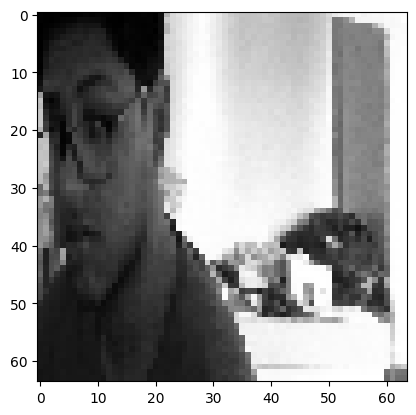

File: testNeutral1.jpg
Predicted Emotion: angry
Probability Distribution: [9.7460628e-01 1.3751588e-09 1.6771610e-03 1.0014474e-08 4.6279620e-06
 2.1428501e-05 2.3690451e-02]
------------------------
1/1 [==============================] - 0s 40ms/step


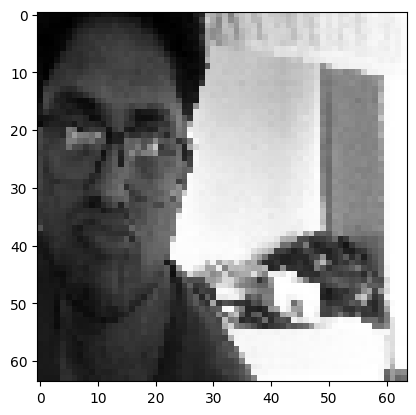

File: testSad.jpg
Predicted Emotion: fear
Probability Distribution: [6.5076412e-05 4.7694467e-21 8.6153811e-01 1.3715778e-01 6.1730121e-04
 6.1297539e-04 8.6960399e-06]
------------------------


In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import os
from faces import extract_face
import matplotlib.pyplot as plt

# Load the saved model
model = load_model('emotion_detection_model_v2.h5')

# Define the emotion mapping
emotion_mapping = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'neutral',
    5: 'sad',
    6: 'surprise'
}

# Folder path containing the test images
test_folder = 'selfTest'

# Iterate over each file in the test folder
for filename in os.listdir(test_folder):
    # Load and preprocess the image
    image_path = os.path.join(test_folder, filename)
    face = extract_face(image_path)

    if face is not None:
        # Preprocess the extracted face
        face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        face = cv2.resize(face, (64, 64))
        face = face.astype('float32') / 255.0
        face = np.expand_dims(face, axis=0)
        face = np.expand_dims(face, axis=-1)

        # Make predictions
        predictions = model.predict(face)
        predicted_class = np.argmax(predictions[0])
        predicted_emotion = emotion_mapping[predicted_class]

        # Show the image
        plt.imshow(face[0, :, :, 0], cmap='gray')
        plt.show()

        # Print the predicted emotion and probability distribution
        print('File:', filename)
        print('Predicted Emotion:', predicted_emotion)
        print('Probability Distribution:', predictions[0])
        print('------------------------')
    else:
        print('No face detected in', filename)


<h4>Test with camera</h4>

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import numpy as np

# Load the saved model
model = load_model('emotion_detection_model_v1.h5')

# Define the emotion mapping
emotion_mapping = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'neutral',
    5: 'sad',
    6: 'surprise'
}

# Function to extract human face from image using HOG algorithm
def extract_face(image):
    # Load the pre-trained HOG face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Extract the first detected face (assuming only one face is present)
    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        face = image[y:y+h, x:x+w]
        return (face, (x, y, w, h))

    return (None, None)

# Open the video capture
cap = cv2.VideoCapture(0)

while True:
    # Read the frame from the video capture
    ret, frame = cap.read()

    # Extract the face from the frame
    face, face_coords = extract_face(frame)

    if face is not None:
        # Preprocess the extracted face
        face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        face = cv2.resize(face, (64, 64))
        face = face.astype('float32') / 255.0
        face = np.expand_dims(face, axis=0)
        face = np.expand_dims(face, axis=-1)

        # Make predictions
        predictions = model.predict(face)
        predicted_class = np.argmax(predictions[0])
        predicted_emotion = emotion_mapping[predicted_class]

        # Mark the predicted emotion on the frame
        (x, y, w, h) = face_coords
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, predicted_emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Display the frame
    cv2.imshow('Emotion Detection', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture
cap.release()
cv2.destroyAllWindows()


<h1>TODO</h1>
<h4>Multiple faces in the same image</h4>
<h4>Combine multiple images into one</h4>
<h4>Try vj for face recognition</h4>
blanks grid with random images, and spaces, random grid